<a href="https://colab.research.google.com/github/SWAGAT2550/project_datasci/blob/main/demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/SWAGAT2550/project_datasci/main/train.csv")
meal_df = pd.read_csv("https://raw.githubusercontent.com/SWAGAT2550/project_datasci/main/meal_info.csv")
center_df = pd.read_csv("https://raw.githubusercontent.com/SWAGAT2550/project_datasci/main/fulfilment_center_info.csv")
data= df.merge(center_df,left_on = 'center_id', right_on = 'center_id',how="left")
data= data.merge(meal_df,left_on = 'meal_id', right_on = 'meal_id',how="left")
data.head(10)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian
5,1270037,1,55,1248,251.23,252.23,0,0,28,647,56,TYPE_C,2.0,Beverages,Indian
6,1191377,1,55,1778,183.36,184.36,0,0,190,647,56,TYPE_C,2.0,Beverages,Italian
7,1499955,1,55,1062,182.36,183.36,0,0,391,647,56,TYPE_C,2.0,Beverages,Italian
8,1025244,1,55,2707,193.06,192.06,0,0,472,647,56,TYPE_C,2.0,Beverages,Italian
9,1054194,1,55,1207,325.92,384.18,0,1,676,647,56,TYPE_C,2.0,Beverages,Continental


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

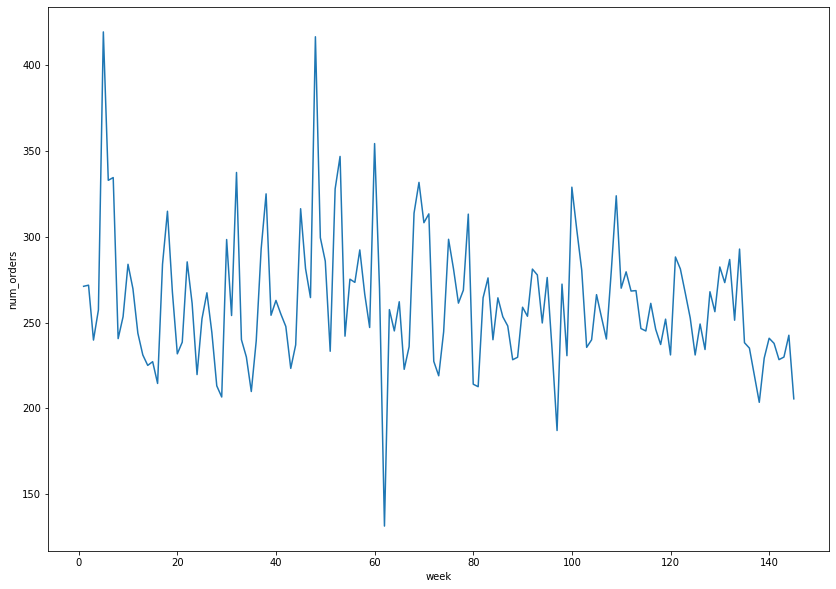

In [7]:
plt.figure(figsize=(14, 10))
sns.lineplot(data=data, x="week", y="num_orders",ci=None)

Text(0, 0.5, 'num_orders')

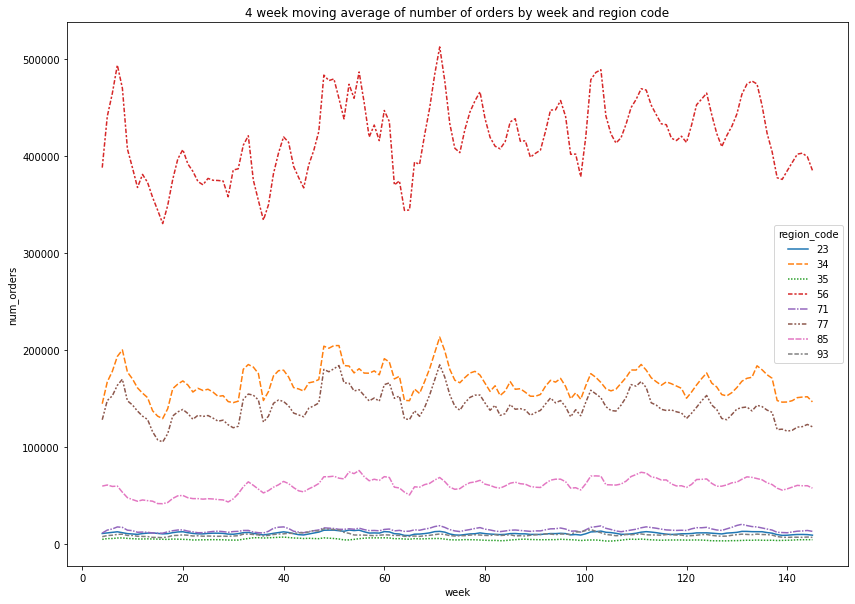

In [8]:
region_table = pd.pivot_table(data, values='num_orders', index=['week'],
                    columns=['region_code'], aggfunc=np.sum)
plt.figure(figsize=(14, 10))
sns.lineplot(data=region_table.rolling(window=4).mean()).set(title='4 week moving average of number of orders by week and region code')
plt.ylabel('num_orders')

Text(0, 0.5, 'num_orders')

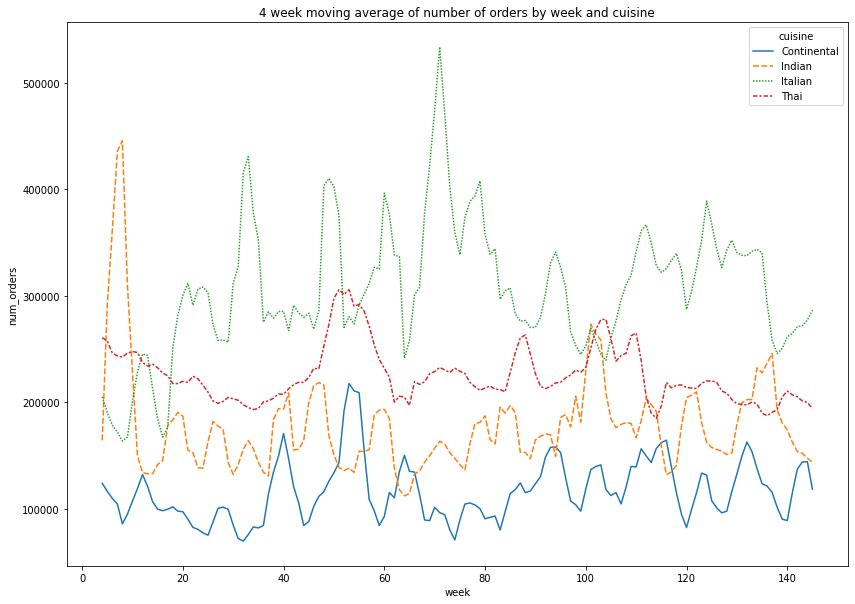

In [9]:
cuisine_table = pd.pivot_table(data, values='num_orders', index=['week'],
                    columns=['cuisine'], aggfunc=np.sum)
plt.figure(figsize=(14, 10))
sns.lineplot(data=cuisine_table.rolling(window=4).mean()).set(title='4 week moving average of number of orders by week and cuisine')
plt.ylabel('num_orders')

[Text(0.5, 1.0, 'Average num of orders by center type')]

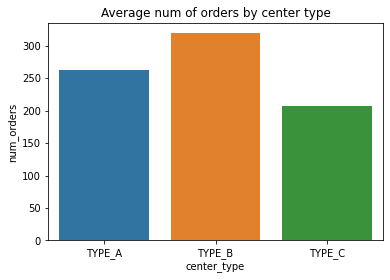

In [10]:
center_type_data = data.groupby(['center_type'])['num_orders'].mean()
center_type_data = pd.DataFrame({ 'center_type': center_type_data.index, 'num_orders': center_type_data.values })
sns.barplot(data=center_type_data,x="center_type",y="num_orders").set(title='Average num of orders by center type')

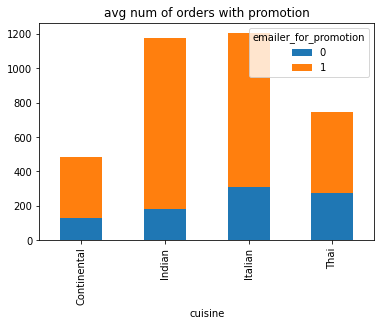

In [11]:
cuisine_table = pd.pivot_table(data, values='num_orders', index=['cuisine'],
                    columns=['emailer_for_promotion'], aggfunc=np.average)
cuisine_table.plot(kind='bar',stacked=True,legend=True,title="avg num of orders with promotion")

In [12]:
operation_area= data.groupby(['city_code'])['op_area'].sum()
num_orders= data.groupby(['city_code'])['num_orders'].sum()
operation_area = pd.DataFrame({ 'city_code': operation_area.index, 'operation_area':operation_area.values , 'num_orders': num_orders.values })
operation_area= operation_area.merge(center_df[["city_code","region_code"]],left_on = 'city_code', right_on = 'city_code',how="left")

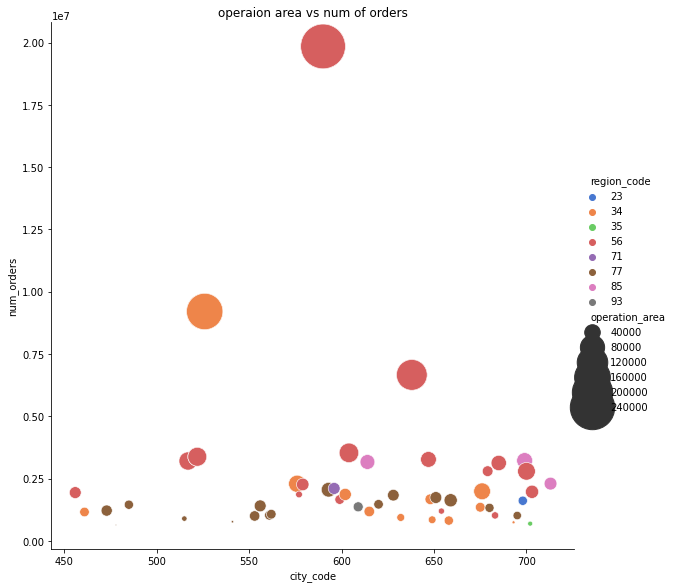

In [13]:
sns.relplot(x="city_code", y="num_orders",hue="region_code", size="operation_area",
            sizes=(1, 2000), palette="muted",height=8, data=operation_area).set(title="operaion area vs num of orders")

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

In [15]:
def one_hot_encode(features_to_encode, dataset):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(dataset[features_to_encode])

    encoded_cols = pd.DataFrame(encoder.transform(dataset[features_to_encode]),columns=encoder.get_feature_names())
    dataset = dataset.drop(columns=features_to_encode)
    for cols in encoded_cols.columns:
        dataset[cols] = encoded_cols[cols]
    return dataset

In [19]:

data = data.drop(["id"],axis=1)
features_to_encode = ['meal_id','city_code',"center_id",'center_type', 'category', 'cuisine']
data = one_hot_encode(features_to_encode, data)


KeyError: ignored

In [20]:
y = data["num_orders"]
X= data.drop(["num_orders"],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
RF_pipe = make_pipeline(StandardScaler(),RandomForestRegressor())
RF_pipe.fit(X_train, y_train)
RF_train_y_pred = RF_pipe.predict(X_test)
print(RF_pipe.score(X_test, y_test))
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(y_test, RF_train_y_pred)))

0.858486775749855
RMSLE: 48.810102820904525


In [22]:
RF_pipe = make_pipeline(StandardScaler(),RandomForestRegressor(n_estimators = 200))
RF_pipe.fit(X_train, y_train)
RF_train_y_pred = RF_pipe.predict(X_test)
print(RF_pipe.score(X_test, y_test))
print('RMSLE:', 100*np.sqrt(metrics.mean_squared_log_error(y_test, RF_train_y_pred)))

0.8575802149441011
RMSLE: 48.71193386076475


In [24]:
OH_test_y_pred = RF_pipe.predict(X_test)

submission = pd.DataFrame(data=OH_test_y_pred, index=X_test.index, columns = ['num_orders'])
submission.reset_index(inplace=True)
submission.to_csv('./submission.csv')
submission

,index,num_orders
0,203536,73.465
1,301801,232.545
2,254032,264.015
3,339158,30.310
4,3203,407.690
...,...,...
150656,418537,592.280
150657,453334,135.290
150658,126678,19.900
150659,335876,211.980
